# NLLB-200 Training Data Size Estimation

There are no official numbers about the amount of data for each language which was used to train the NLLB-200 model. Therefore, here I attempt to estimate the distribution over the languages.

Training data consists of the following portions:

- Primary bitext
    - Public data
    - Seed data
- Mined bitext
- Backtranslated bitext

For more information on NLLB-200 training data, see https://github.com/facebookresearch/fairseq/tree/nllb/examples/nllb/data.

In [2]:
import json
import os
import re
from collections import defaultdict
from urllib.request import urlretrieve

import pandas as pd

## Primary Bitext

### Public Data

The script `download_parallel_copora.py` handles automatic donwloading of many public MT datasets which were used for training NLLB. The total size of those datasets is ~27.5GB.

In [2]:
PUBL_PATH = "/Users/hirak/nllb_train_data/primary/public_data"

EXCLUDED_FILES = ["cached_lm_test.en", "test.fm.prob", "get_zero_shot_pairs.py",
                  "zeroshotcorpstats", "README", "train.tsv", ".DS_Store"]

# Mapping of ISO 639-1 codes to ISO 639-3 codes
ISO_MAP = {"bn": "ben", "en": "eng", "gu": "guj", "hi": "hin", "kn": "kan",
           "ml": "mal", "mr": "mar", "or": "ory", "pa": "pan", "ta": "tam",
           "te": "tel", "ur": "urd", "fr": "fra"}

In [ ]:
# NOT FOR USE: an attempt to account for duplicate training data in a language,
# but due to inconsistencies in the data, this was not used

datasets_publ = sorted(os.listdir(PUBL_PATH))
datasets_publ.remove(".DS_Store")

file_paths_publ = []

for dataset in datasets_publ:
    dataset_path = os.path.join(PUBL_PATH, dataset)
    dataset_langs = set()
    for parent_dir, _, dir_files in os.walk(dataset_path):
        dir_files = [file for file in dir_files if file not in EXCLUDED_FILES]
        for file in dir_files:
            file_lang = file.split(".")[1]
            file_lang = ISO_MAP.get(file_lang, file_lang)
            if not file_lang in dataset_langs:  # Avoid duplicate data
                dataset_langs.add(file_lang)
                file_path = os.path.join(parent_dir, file)
                file_paths_publ.append(file_path)

In [3]:
file_paths_publ = []

for parent_dir, _, dir_file_names in os.walk(PUBL_PATH):
    dir_file_names = [n for n in dir_file_names if n not in EXCLUDED_FILES]
    dir_file_paths = [parent_dir + "/" + name for name in dir_file_names]
    file_paths_publ.extend(dir_file_paths)

In [5]:
lang_sizes_publ = defaultdict(int)

for path in file_paths_publ:
    lang = path.split(".")[-1]
    lang = ISO_MAP.get(lang, lang)
    with open(path) as file:
        num_sents = len(file.readlines())
        lang_sizes_publ[lang] += num_sents

In [24]:
df = pd.DataFrame(lang_sizes_publ.items(), columns=["lang", "num_sents_publ"])
df.sort_values("lang", inplace=True)

In [25]:
df.to_csv("lang_train_size.csv", index=False)

### GERL

The [GELR (Ewe-Eng) dataset](https://www.kaggle.com/yvicherita/ewe-language-corpus) couldn't be automatically donwloaded, as it requires authorization, so it was downloaded manually.

In [14]:
GERL_PATH = "/Users/hirak/nllb_train_data/primary/gerl.json"

In [ ]:
gerl = json.load(open(GERL_PATH))
data = gerl[2]["data"]

In [31]:
num_sents_gerl = 0

for pair in data:
    if pair["ee_sentence"] and pair["eng_sentence"]:
        num_sents_gerl += 1

### Seed

There are 6193 sentences for each language. More information can be found here: https://github.com/facebookresearch/flores/tree/main/nllb_seed.

In [9]:
df = pd.read_csv("lang_train_size.csv")

In [3]:
SEED_PATH = "/Users/hirak/nllb_train_data/primary/seed"

In [10]:
file_paths_seed = []

for parent_dir, _, dir_file_names in os.walk(SEED_PATH):
    dir_file_paths = [parent_dir + "/" + name for name in dir_file_names]
    file_paths_seed.extend(dir_file_paths)

In [11]:
lang_sizes_seed = defaultdict(int)

for path in file_paths_seed:
    lang = path.split("/")[-1]
    with open(path) as file:
        num_sents = len(file.readlines())
        lang_sizes_seed[lang] = 6193

In [12]:
for lang, size in lang_sizes_seed.items():
    if lang in df["lang"].values:
        df.loc[df["lang"] == lang, "num_sents_seed"] = size
    else:
        df = df.append({"lang": lang, "num_sents_seed": size}, ignore_index=True)

/var/folders/_9/cn5fn8814d515j08vlk28lmm0000gn/T/ipykernel_3974/2785416483.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"lang": lang, "num_sents_seed": size}, ignore_index=True)
/var/folders/_9/cn5fn8814d515j08vlk28lmm0000gn/T/ipykernel_3974/2785416483.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"lang": lang, "num_sents_seed": size}, ignore_index=True)
/var/folders/_9/cn5fn8814d515j08vlk28lmm0000gn/T/ipykernel_3974/2785416483.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"lang": lang, "num_sents_seed": size}, ignore_index=True)
/var/folders/_9/cn5fn8814d515j08vlk28lmm0000gn/T/ipykernel_3974/2785416483.py:5: FutureWarning: The frame.append method is depreca

In [13]:
df.fillna(0, inplace=True)
df = df.astype({"num_sents_publ": int, "num_sents_gerl": int})
df.sort_values("lang", inplace=True, ignore_index=True)

In [14]:
df.to_csv("lang_train_size.csv", index=False)

## Mined Bitext

### Retrieving Metadata URLs

In [50]:
README_PATH = "/Users/hirak/nllb_train_data/mined/README.md"

url_re = re.compile(
    r"https://dl.fbaipublicfiles.com/nllb/data/\w{3}_\w{4}-\w{3}_\w{4}.meta.v1.xz"
)

In [51]:
with open(README_PATH) as f:
    readme = f.read()

urls = url_re.findall(readme)

with open("mined_metadata_urls.txt", "w") as f:
    for url in urls:
        f.write(url + "\n")

In [ ]:
sbatch lang_sizes_mined.sh

## Backtranslated Text

Although the official NLLB repository provides a script for constructing aligned sentence pairs via backtranslation for a given dataset, there's no information about which specific datasets were backtranslated and used for training the NLLB model. The NLLB training data therefore is estimated without accounting for backtranslated data.

## Summary

In [3]:
df = pd.read_csv("lang_train_size.csv")

In [5]:
df["num_sents_total"] = (df["num_sents_publ"] + df["num_sents_seed"]
                         + df["num_sents_gerl"] + df["num_sents_mined"])

In [10]:
df["fraction_total"] = df["num_sents_total"] / df["num_sents_total"].sum()

In [19]:
df.to_csv("lang_train_size.csv", index=False)

## Plotting

In [35]:
df_no_eng = df[df["lang"] != "eng_Latn"]

<AxesSubplot: ylabel='lang'>

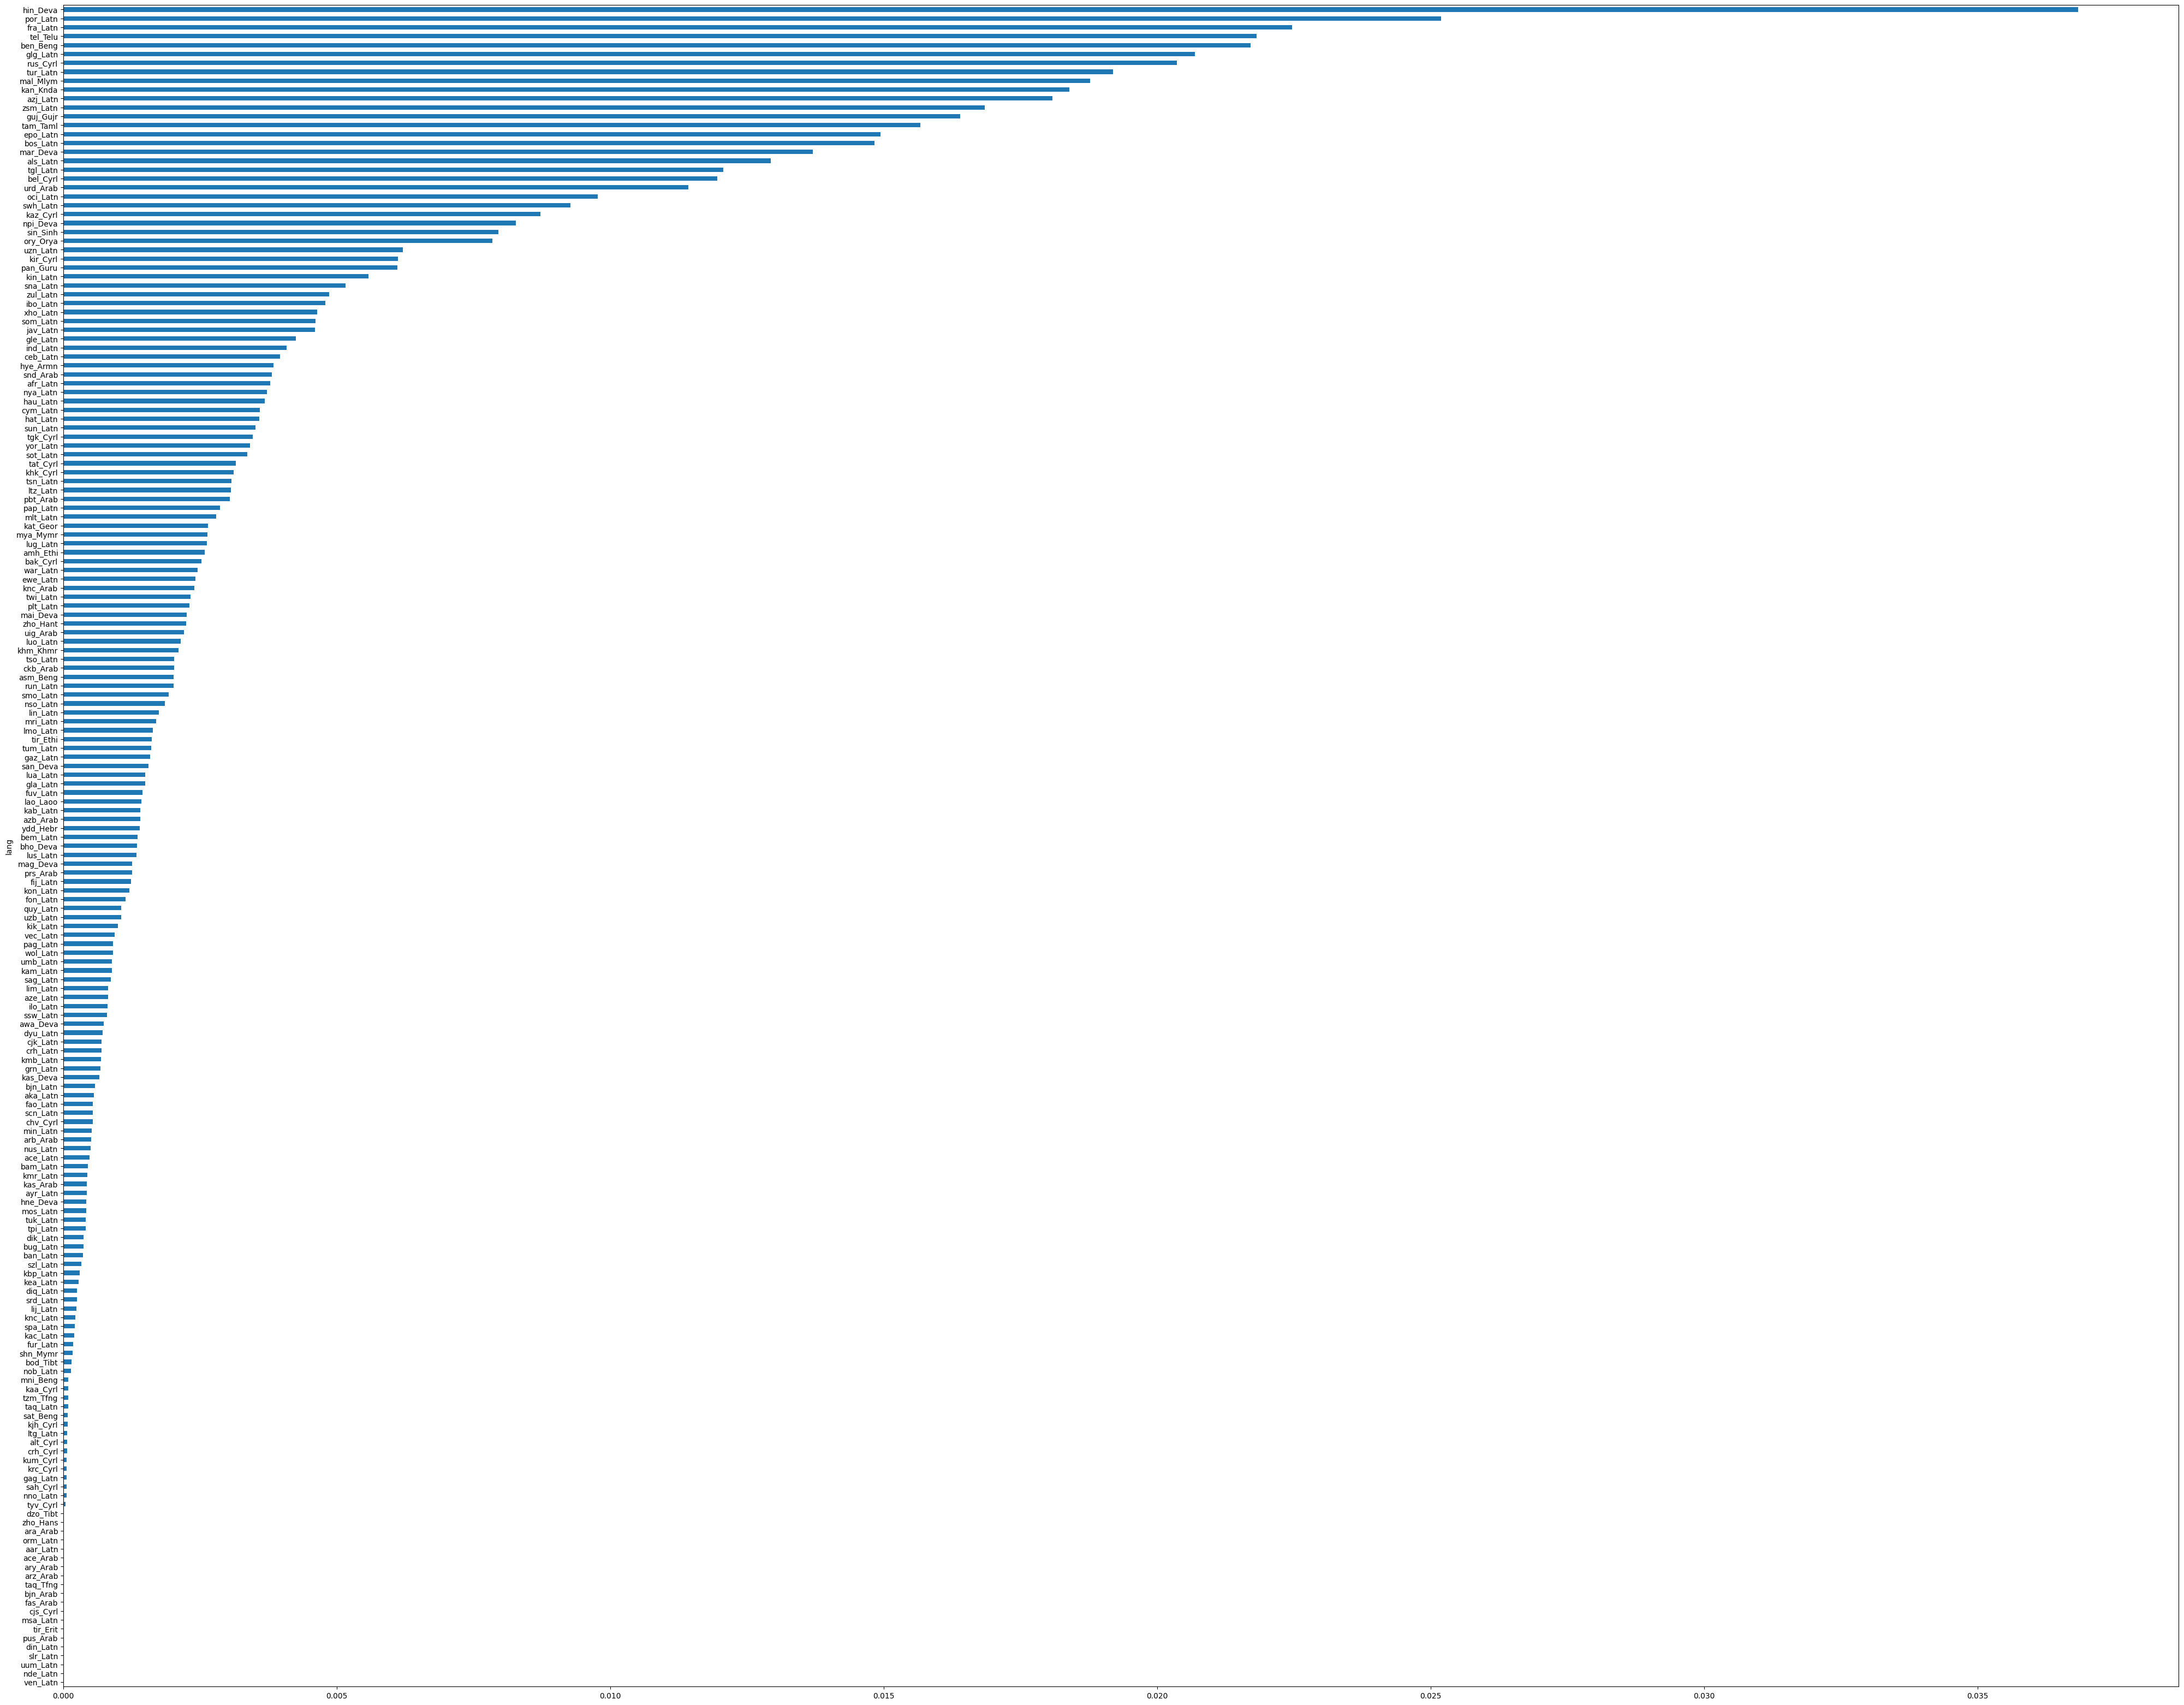

In [36]:
df_sorted = df_no_eng.sort_values("fraction_total", ascending=True)
df_sorted.plot.barh(x="lang", y="fraction_total", figsize=(50, 40), legend=False)